<a href="https://colab.research.google.com/github/gatienseven7/Adversarial_Robustness_Challenge/blob/main/Mnist_Fgsm_Adversarial.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [12]:
from google.colab import files

uploaded = files.upload()

for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))

Saving train.csv to train (1).csv
User uploaded file "train (1).csv" with length 76775041 bytes


Shape of df: (32696, 785)
x_train shape: (26156, 28, 28, 1)
x_test shape: (6540, 28, 28, 1)
x_test shape: (6540, 28, 28, 1)
x_test_adv shape: (10, 28, 28, 1)


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
Epoch 1/5
184/184 ━━━━━━━━━━━━━━━━━━━━ 8s 40ms/step - accuracy: 0.8102 - loss: 0.6655 - val_accuracy: 0.9465 - val_loss: 0.1848
Epoch 2/5
184/184 ━━━━━━━━━━━━━━━━━━━━ 8s 41ms/step - accuracy: 0.9646 - loss: 0.1264 - val_accuracy: 0.9637 - val_loss: 0.1208
Epoch 3/5
184/184 ━━━━━━━━━━━━━━━━━━━━ 8s 41ms/step - accuracy: 0.9791 - loss: 0.0730 - val_accuracy: 0.9767 - val_loss: 0.0915
Epoch 4/5
184/184 ━━━━━━━━━━━━━━━━━━━━ 8s 42ms/step - accuracy: 0.9822 - loss: 0.0551 - val_accuracy: 0.9733 - val_loss: 0.0886
Epoch 5/5
184/184 ━━━━━━━━━━━━━━━━━━━━ 7s 40ms/step - accuracy: 0.9896 - loss: 0.0377 - val_accuracy: 0.9759 - val_loss: 0.0865
205/205 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.9768 - loss: nan
Test Accuracy (after adversarial training): 0.9775229096412659
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - accuracy: 1.0000 - loss: 0.0107
Adversarial Accuracy (after adversarial training): [0.010689239017665386, 1.0]


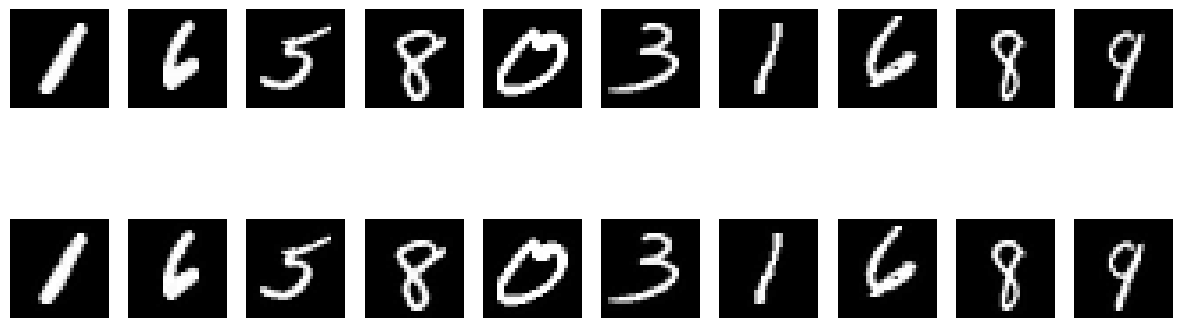

In [29]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from tensorflow.keras.utils import to_categorical
import matplotlib.pyplot as plt

# 1. Chargement et prétraitement des données depuis train.csv
df = pd.read_csv("train.csv")
print(f"Shape of df: {df.shape}")  # Vérification des dimensions du DataFrame

y = df["label"].values
X = df.drop("label", axis=1).values

X = X.astype("float32") / 255.0
X = X.reshape(-1, 28, 28, 1)  # Changement de forme pour l'image
y_cat = to_categorical(y, 10)

# 2. Division manuelle des données train/test
train_size = int(0.8 * X.shape[0])  # Utilisation de 80% des données pour l'entraînement
x_train = X[:train_size]
y_train_cat = y_cat[:train_size]
x_test = X[train_size:]
y_test_cat = y_cat[train_size:]
y_test = y[train_size:]

print(f"x_train shape: {x_train.shape}")
print(f"x_test shape: {x_test.shape}")

# 3. Construction du modèle CNN
def build_model():
    model = Sequential([
        Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=(28, 28, 1)),
        MaxPooling2D(pool_size=(2, 2)),
        Flatten(),
        Dense(128, activation='relu'),
        Dense(10, activation='softmax')
    ])
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

model = build_model()

# 5. Générer des exemples adversariaux avec un epsilon plus petit
def generate_adversarial_examples(model, x, y, epsilon=0.01):  # Réduit epsilon
    x = tf.convert_to_tensor(x, dtype=tf.float32)
    y = tf.convert_to_tensor(y, dtype=tf.float32)

    x_adv = x.numpy()  # Copie des images d'origine avant perturbation

    model.trainable = True

    with tf.GradientTape() as tape:
        tape.watch(x)
        predictions = model(x)
        loss = tf.keras.losses.categorical_crossentropy(y, predictions)

    gradients = tape.gradient(loss, x)
    perturbations = epsilon * tf.sign(gradients)

    # Clipper les gradients pour éviter les valeurs trop grandes
    perturbations = tf.clip_by_value(perturbations, -0.3, 0.3)  # Limite la perturbation

    x_adv = x + perturbations
    x_adv = tf.clip_by_value(x_adv, 0.0, 1.0)  # Limiter les valeurs entre 0 et 1

    return x_adv.numpy()

# Générer 10 exemples adversariaux
x_test_adv = generate_adversarial_examples(model, x_test[:10], y_test_cat[:10], epsilon=0.01)

# Vérification des dimensions des données
print(f"x_test shape: {x_test.shape}")
print(f"x_test_adv shape: {x_test_adv.shape}")

# Prédictions sur les images adversariales
predictions_adv = model.predict(x_test_adv, batch_size=128)

# 7. Réentraîner le modèle avec des exemples adversariaux
x_train_combined = np.concatenate((x_train, x_test_adv), axis=0)
y_train_combined = np.concatenate((y_train_cat, y_test_cat[:10]), axis=0)

model = build_model()
model.fit(x_train_combined, y_train_combined, epochs=5, batch_size=128, validation_split=0.1)

# 8. Évaluation du modèle sur le jeu de test normal
loss, acc = model.evaluate(x_test, y_test_cat)
print("Test Accuracy (after adversarial training):", acc)

# 9. Vérification de l'impact sur les exemples adversariaux
acc_adv = model.evaluate(x_test_adv, y_test_cat[:10])
print("Adversarial Accuracy (after adversarial training):", acc_adv)

# Affichage des exemples adversariaux après les prédictions
fig, axs = plt.subplots(2, 10, figsize=(15, 5))
for i in range(10):
    axs[0, i].imshow(x_test[i].reshape(28, 28), cmap='gray')
    axs[0, i].axis('off')
    axs[1, i].imshow(x_test_adv[i].reshape(28, 28), cmap='gray')
    axs[1, i].axis('off')

plt.show()
